In [1]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import librosa as lb
import soundfile as sf
import tensorflow as tf
from tensorflow import keras
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.regularizers import L2

## Load in standardized data

In [2]:
max_pct_zero = 0.5
folders = glob('data\\MER_taffc_standard\\*')
paths = []
for folder in folders:
    directory = folder + '\\*.wav'
    paths += glob(directory)
ffts = []
db_ffts = []
db_norms = []
qs = []
for path in tqdm(paths):
    seg, sr = lb.load(path)
    n = seg.shape[0]
    if (seg == 0).sum()/n <= max_pct_zero:
        fft = lb.feature.melspectrogram(y=seg, n_fft=1024, hop_length=564)
        ffts.append(fft)
        
        db_fft = lb.power_to_db(fft, ref=np.max)
        db_ffts.append(db_fft)
        
        qs.append(path.split('\\')[2])
print(f'number of clips: {len(ffts)}')
pd.Series(qs).value_counts()

  0%|          | 0/5392 [00:00<?, ?it/s]

number of clips: 5382


Q2    1349
Q4    1347
Q3    1346
Q1    1340
dtype: int64

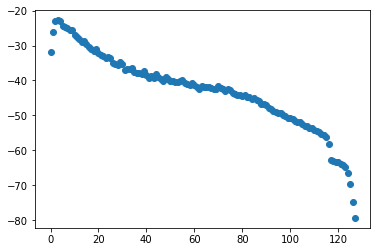

In [3]:
y = np.mean(db_ffts, axis=(0, 2))
x = range(y.shape[0])
plt.scatter(x, y)
plt.show()

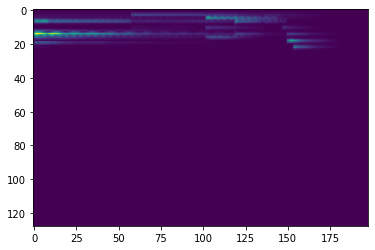

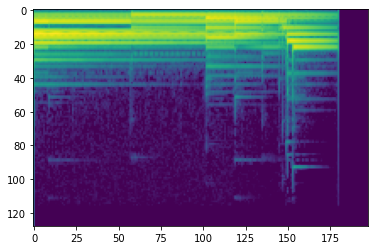

In [4]:
plt.imshow(ffts[-1])
plt.figure()
plt.imshow(db_ffts[-1])
plt.show()

## Model

In [5]:
mels = 128
ts   = 198

In [6]:
lrelu = keras.layers.LeakyReLU(alpha=0)
l2 = L2(l2=0.001)

In [7]:
def build():
    X = keras.Input(shape=(mels, ts, 1))
    model = keras.models.Sequential()
    model.add(X)
    model.add(Conv2D(64, 3, activation=lrelu, padding='same'))
    model.add(Conv2D(64, 3, activation=lrelu, padding='same'))
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Conv2D(64, 3, activation=lrelu, padding='same'))
    model.add(Conv2D(64, 3, activation=lrelu, padding='same'))
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Conv2D(128, 3, activation=lrelu, padding='same'))
    model.add(MaxPooling2D(pool_size=3, strides=3))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, 3, activation=lrelu, padding='same'))
    model.add(MaxPooling2D(pool_size=3, strides=3))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, 3, activation=lrelu, padding='same'))
    model.add(MaxPooling2D(pool_size=3, strides=3))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation=lrelu, kernel_regularizer=l2))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation=lrelu, kernel_regularizer=l2))
    model.add(Dropout(0.4))
    model.add(Dense(4, activation='softmax'))
    return model
model = build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 198, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 198, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 99, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 99, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 49, 64)       0         
 2D)                                                    

In [8]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

## Train/test split

In [9]:
def train_test_split(ffts, qs, test_size=0.2):
    q1 = []; q2 = []; q3 = []; q4 = []
    for i, data in enumerate(zip(ffts, qs)):
        fft, q = data
        if q == 'Q1':
            q1.append(fft)
        elif q == 'Q2':
            q2.append(fft)
        elif q == 'Q3':
            q3.append(fft)
        else:
            q4.append(fft)
    q1 = np.array(q1).reshape((mels, ts, -1))
    q2 = np.array(q2).reshape((mels, ts, -1))
    q3 = np.array(q3).reshape((mels, ts, -1))
    q4 = np.array(q4).reshape((mels, ts, -1))
            
    n1 = q1.shape[-1]
    q1_test_size = int(test_size*n1)
    q1_test_ind = np.random.choice(range(n1), size=q1_test_size, replace=False)
    q1_test_mask = np.zeros(n1, bool)
    q1_test_mask[q1_test_ind] = True
    n2 = q2.shape[-1]
    q2_test_size = int(test_size*n2)
    q2_test_ind = np.random.choice(range(n2), size=q2_test_size, replace=False)
    q2_test_mask = np.zeros(n2, bool)
    q2_test_mask[q2_test_ind] = True
    n3 = q3.shape[-1]
    q3_test_size = int(test_size*n3)
    q3_test_ind = np.random.choice(range(n3), size=q3_test_size, replace=False)
    q3_test_mask = np.zeros(n3, bool)
    q3_test_mask[q3_test_ind] = True
    n4 = q4.shape[-1]
    q4_test_size = int(test_size*n4)
    q4_test_ind = np.random.choice(range(n4), size=q4_test_size, replace=False)
    q4_test_mask = np.zeros(n4, bool)
    q4_test_mask[q4_test_ind] = True
    
    q1_test = q1[:, :, q1_test_mask]
    q1_train = q1[:, :, ~q1_test_mask]
    q2_test = q2[:, :, q2_test_mask]
    q2_train = q2[:, :, ~q2_test_mask]
    q3_test = q3[:, :, q3_test_mask]
    q3_train = q3[:, :, ~q3_test_mask]
    q4_test = q4[:, :, q4_test_mask]
    q4_train = q4[:, :, ~q4_test_mask]
    
    X_test = np.concatenate([q1_test, q2_test, q3_test, q4_test], axis=-1)
    X_test = X_test.reshape((-1, mels, ts, 1))
    y_test = np.array([[1, 0, 0, 0]]*q1_test_size + [[0, 1, 0, 0]]*q2_test_size +\
                      [[0, 0, 1, 0]]*q3_test_size + [[0, 0, 0, 1]]*q4_test_size)
    index = list(range(X_test.shape[0]))
    np.random.shuffle(index)
    X_test = X_test[index, :, :, :]; y_test = y_test[index, :]
   
    X_train = np.concatenate([q1_train, q2_train, q3_train, q4_train], axis=-1)
    X_train = X_train.reshape((-1, mels, ts, 1))
    y_train = np.array([[1, 0, 0, 0]]*(n1 - q1_test_size) + [[0, 1, 0, 0]]*(n2 - q2_test_size) +\
                       [[0, 0, 1, 0]]*(n3 - q3_test_size) + [[0, 0, 0, 1]]*(n4 - q4_test_size))
    index = list(range(X_train.shape[0]))
    np.random.shuffle(index)
    X_train = X_train[index, :, :, :]; y_train = y_train[index, :]
    
    return X_train, y_train, X_test, y_test

In [39]:
def standardize(X, train_mean=None, train_std=None):
    mean = np.mean(X, axis=(0,2)).reshape((1,mels,1,1))
    std  = np.std(X, axis=(0,2)).reshape((1,mels,1,1))
    if train_mean is not None:
        mean = train_mean
    if train_std is not None:
        std = train_std
    X_standard = (X - mean)/std 
    return mean, std, X_standard

In [10]:
def standardize(X, train_mean=None, train_std=None):
    mean = np.mean(X)
    std  = np.std(X)
    if train_mean is not None:
        mean = train_mean
    if train_std is not None:
        std = train_std
    X_standard = (X - mean)/std 
    return mean, std, X_standard

In [11]:
X_train, y_train, X_test, y_test = train_test_split(db_ffts, qs, test_size=0.2)

In [12]:
mean, std, X_train = standardize(X_train)
_, _, X_test       = standardize(
    X_test, 
    train_mean=mean, 
    train_std=std
)
X_train.shape, X_test.shape

((4307, 128, 198, 1), (1075, 128, 198, 1))

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=4, restore_best_weights=True)
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=45,
    batch_size=128,
    callbacks=[callback],
    validation_data=(X_test, y_test)
)

Epoch 1/45
 4/34 [==>...........................] - ETA: 45:10 - loss: 1.8977 - categorical_accuracy: 0.2539

In [ ]:
model.save('mer_model_1_31_23.h5')

1/25: validation accuracy ~25%

1/26: validation accuracy ~25%

1/30: validation accuracy ~31%